<a href="https://colab.research.google.com/github/sugi-san/aphantasia/blob/master/text2movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

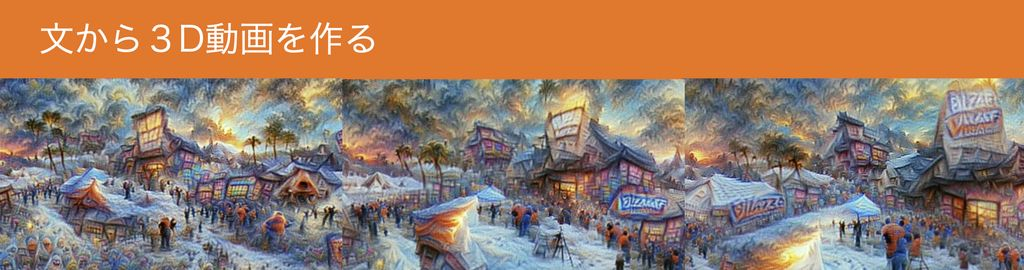

In [ ]:
#@title **1.GPU チェック**
#@markdown 割り当てられたGPUが**T4/P4/P100**のどれかであることを確認してください\
#@markdown　そうでない場合は、**「ランタイム／ランタイム接続解除して削除」**をクリックし、再トライして下さい
!nvidia-smi -L

In [ ]:
#@title **2.セットアップ**

!pip install ftfy==5.8 transformers
!pip install gputil ffpb 

# !apt-get -qq install ffmpeg
work_dir = '/content/illustrip'
import os
os.makedirs(work_dir, exist_ok=True)
%cd $work_dir

import os
import io
import time
import math
import random
import imageio
import numpy as np
import PIL
from base64 import b64encode
import shutil
from easydict import EasyDict as edict
a = edict()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torch.autograd import Variable

from IPython.display import HTML, Image, display, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import ipywidgets as ipy
from google.colab import output, files

import warnings
warnings.filterwarnings("ignore")

!pip install git+https://github.com/openai/CLIP.git --no-deps
import clip
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
!pip install kornia
import kornia
!pip install lpips
import lpips
!pip install PyWavelets==1.1.1
!pip install git+https://github.com/fbcotter/pytorch_wavelets

!pip install git+https://github.com/eps696/aphantasia
from aphantasia.image import to_valid_rgb, fft_image, rfft2d_freqs, img2fft, pixel_image, un_rgb
from aphantasia.utils import basename, file_list, img_list, img_read, txt_clean, plot_text, old_torch
from aphantasia.utils import slice_imgs, derivat, pad_up_to, slerp, checkout, sim_func, latent_anima
from aphantasia import transforms
from aphantasia.progress_bar import ProgressIPy as ProgressBar

%cd $work_dir
!git clone https://github.com/cedro3/aphantasia.git --recursive
work_dir = os.path.join(work_dir, 'aphantasia')
%cd $work_dir
from depth import depth
# !wget https://github.com/eps696/aphantasia/blob/master/mask.jpg?raw=true -O mask.jpg
depth_mask_file = os.path.join(work_dir, 'depth', 'mask.jpg')
%cd /content

def save_img(img, fname=None):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1,2,0))  
  img = np.clip(img*255, 0, 255).astype(np.uint8)
  if fname is not None:
    imageio.imsave(fname, np.array(img))
    imageio.imsave('result.jpg', np.array(img))

def makevid(seq_dir, size=None):
  char_len = len(basename(img_list(seq_dir)[0]))
  out_sequence = seq_dir + '/%0{}d.jpg'.format(char_len)
  out_video = seq_dir + '.mp4'
  print('.. generating video ..')
  !ffmpeg -y -v warning -i $out_sequence -crf 18 $out_video

%cd /content/illustrip/aphantasia/
from function import *


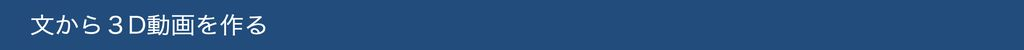

In [ ]:
#@title **3.動画の作成**

# ============
#     Setting   
# ============
%cd /content/illustrip/aphantasia/

content = "Pollinations is a system designed to produce joy in the form of honey" #@param {type:"string"}
style = "Illustration by Ernst Haeckel" #@param {type:"string"}
resume = False #@param {type:"boolean"}

texts = [content]
styles = [style]
workname = txt_clean(content)[:44]

if resume:
  print('Upload file to resume from')
  resumed = files.upload()
  resumed = list(resumed.keys())  
  size_opt(resumed[0]) 
  resumed_filename = resumed[0]

assert len(texts) > 0 and len(texts[0]) > 0, 'No input text[s] found!'
tempdir = os.path.join(work_dir, workname)
os.makedirs(tempdir, exist_ok=True)
print('main dir', tempdir)

rotation = True #@param {type:"boolean"}
three_d = True #@param {type:"boolean"}

if rotation:
  rotate = 0.8
else:
  rotate =0

if three_d:
  DepthStrength = 0.01
else:
  DepthStrength =0

sideX = 640 #param {type:"integer"} 
sideY = 360 #param {type:"integer"} 
steps = 200 
frame_step = 100 

# Config
method = 'RGB' 
model = 'ViT-B/32' 

# Setting
align = 'overscan'
colors = 2.3
contrast = 1.2
sharpness = -1.
aug_noise = 0.
smooth = False
interpolate_topics = True
style_power = 1.
samples = 200
save_step = 1
learning_rate = 1.
optimizer = 'adam'
aug_transform = 'fast' #param ["elastic", "custom", "fast", "none"] {allow-input: true}
similarity_function = 'mixed'
macro = 0.4
enforce = 0.
expand = 0.
zoom = 0.012 
shift = 10 
#rotate = 0.8 #@param {type:"number"} #0.8
distort = 0.3
animate_them = True
sample_decrease = 1.
#DepthStrength = 0.
save_depth = False

print(' loading CLIP model..')
model_clip, _ = clip.load(model, jit=old_torch())
modsize = model_clip.visual.input_resolution

#%cd $work_dir
clear_output()
print(' using CLIP model', model)

if resume:
  #img_in = imageio.imread(resumed_bytes)
  img_in = imageio.imread(resumed_filename) ###
  # params_tmp = torch.Tensor(img_in).permute(2,0,1).unsqueeze(0).float().cuda()
  params_tmp = 3.3 * un_rgb(img_in, colors=2.)
  sideY, sideX = img_in.shape[0], img_in.shape[1]
else:
  params_tmp = torch.randn(1, 3, sideY, sideX).cuda() # * 0.01


# =================
#     Add 3D depth   
# =================

depth_model = 'nyu' # @ param ["nyu","kitti"]
#DepthStrength = 0.01 #@param{type:"number"}
save_depth = False #param{type:"boolean"}
MaskBlurAmt = 33 
size = (sideY,sideX)

%cd $work_dir

if DepthStrength != 0:

  if not os.path.exists("AdaBins_nyu.pt"):
    !gdown https://drive.google.com/uc?id=1lvyZZbC9NLcS8a__YPcUP7rDiIpbRpoF
    if not os.path.exists('AdaBins_nyu.pt'):
      !wget https://www.dropbox.com/s/tayczpcydoco12s/AdaBins_nyu.pt
  # if depth_model=='kitti' and not os.path.exists(os.path.join(workdir_depth, "pretrained/AdaBins_kitti.pt")):
    # !gdown https://drive.google.com/uc?id=1HMgff-FV6qw1L0ywQZJ7ECa9VPq1bIoj

  if save_depth:
    depthdir = os.path.join(tempdir, 'depth')
    os.makedirs(depthdir, exist_ok=True)
    print('depth dir', depthdir)
  else:
    depthdir = None

  depth_infer, depth_mask = depth.init_adabins(size=size, model_path='AdaBins_nyu.pt', mask_path=depth_mask_file)

  def depth_transform(img_t, depth_infer, depth_mask, size, depthX=0, scale=1., shift=[0,0], colors=1, depth_dir=None, save_num=0):
    size2 = [s//2 for s in size]
    if not isinstance(scale, float): scale = float(scale[0])
    # d X/Y define the origin point of the depth warp, effectively a "3D pan zoom", [-1..1]
    # plus = look ahead, minus = look aside
    dX = 100. * shift[0] / size[1]
    dY = 100. * shift[1] / size[0]
    # dZ = movement direction: 1 away (zoom out), 0 towards (zoom in), 0.5 stay
    dZ = 0.5 + 32. * (scale-1) 
    img = depth.depthwarp(img_t, depth_infer, depth_mask, size2, depthX, [dX,dY], dZ, save_path=depth_dir, save_num=save_num)
    return img



# =============
#     Generate   
# =============

clear_output() ###

if aug_transform == 'elastic':
  trform_f = transforms.transforms_elastic
  sample_decrease *= 0.95
elif aug_transform == 'custom':
  trform_f = transforms.transforms_custom
  sample_decrease *= 0.95
elif aug_transform == 'fast':
  trform_f = transforms.transforms_fast
  sample_decrease *= 0.95
  print(' using fast aug transforms')
else:
  trform_f = transforms.normalize()

if enforce != 0:
  sample_decrease *= 0.5

samples = int(samples * sample_decrease)
print(' using %s method, %d samples, %s optimizer' % (method, samples, optimizer))
print(' roate = '+str(rotate), 'DepthStrength = '+str(DepthStrength)) ###

def enc_text(txt):
  emb = model_clip.encode_text(clip.tokenize(txt).cuda()[:77])
  return emb.detach().clone()

# Encode inputs
count = 0 # max count of texts and styles
key_txt_encs = [enc_text(txt) for txt in texts]
count = max(count, len(key_txt_encs))
key_styl_encs = [enc_text(style) for style in styles]
count = max(count, len(key_styl_encs))
assert count > 0, "No inputs found!"

# !rm -rf $tempdir
# os.makedirs(tempdir, exist_ok=True)

glob_steps = count * steps # saving
if glob_steps == frame_step: frame_step = glob_steps // 2 # otherwise no motion

outpic = ipy.Output()
outpic

params_tmp = params_tmp.detach()

# animation controls
if animate_them:
  if method == 'RGB':
    m_scale = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[-0.3])
    m_scale = 1 + (m_scale + 0.3) * zoom # only zoom in
  else:
    m_scale = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.6])
    m_scale = 1 - (m_scale-0.6) * zoom # ping pong
  m_shift = latent_anima([2], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.5,0.5])
  m_angle = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.5])
  m_shear = latent_anima([1], glob_steps, frame_step, uniform=True, cubic=True, start_lat=[0.5])
  m_shift = (m_shift-0.5) * shift   * abs(m_scale-1.) / zoom
  m_angle = (m_angle-0.5) * rotate  * abs(m_scale-1.) / zoom
  m_shear = (m_shear-0.5) * distort * abs(m_scale-1.) / zoom

def get_encs(encs, num):
  cnt = len(encs)
  if cnt == 0: return []
  enc_1 = encs[min(num,   cnt-1)]
  enc_2 = encs[min(num+1, cnt-1)]
  return slerp(enc_1, enc_2, steps)

def frame_transform(img, size, angle, shift, scale, shear):
  if old_torch(): # 1.7.1
    img = T.functional.affine(img, angle, shift, scale, shear, fillcolor=0, resample=PIL.Image.BILINEAR)
    img = T.functional.center_crop(img, size)
    img = pad_up_to(img, size)
  else: # 1.8+
    img = T.functional.affine(img, angle, shift, scale, shear, fill=0, interpolation=T.InterpolationMode.BILINEAR)
    img = T.functional.center_crop(img, size) # on 1.8+ also pads
  return img

prev_enc = 0
def process(num):
  global params_tmp, opt_state, params, image_f, optimizer, pbar

  if interpolate_topics:
    txt_encs  = get_encs(key_txt_encs,  num)
    styl_encs = get_encs(key_styl_encs, num)
  else:
    txt_encs  = [key_txt_encs[min(num,  len(key_txt_encs)-1)][0]]  * steps if len(key_txt_encs)  > 0 else []
    styl_encs = [key_styl_encs[min(num, len(key_styl_encs)-1)][0]] * steps if len(key_styl_encs) > 0 else []

  if len(texts)  > 0: print(' ref text: ',  texts[min(num, len(texts)-1)][:80])
  if len(styles) > 0: print(' ref style: ', styles[min(num, len(styles)-1)][:80])

  for ii in range(steps):
    glob_step = num * steps + ii # saving/transforming

    # get encoded inputs
    txt_enc  = txt_encs[ii % len(txt_encs)].unsqueeze(0)   if len(txt_encs)  > 0 else None
    styl_enc = styl_encs[ii % len(styl_encs)].unsqueeze(0) if len(styl_encs) > 0 else None
    
    ### animation: transform frame, reload params

    h, w = sideY, sideX
    
    # transform frame for motion
    scale =       m_scale[glob_step]    if animate_them else 1-zoom
    trans = tuple(m_shift[glob_step])   if animate_them else [0, shift]
    angle =       m_angle[glob_step][0] if animate_them else rotate
    shear =       m_shear[glob_step][0] if animate_them else distort

    if method == 'RGB':
      if DepthStrength != 0:
        params_tmp = depth_transform(params_tmp, depth_infer, depth_mask, size, DepthStrength, scale, trans, colors, depthdir, glob_step)
      params_tmp = frame_transform(params_tmp, (h,w), angle, trans, scale, shear)
      params, image_f, _ = pixel_image([1,3,h,w], resume=params_tmp)
      img_tmp = None

    else: # FFT
      if old_torch(): # 1.7.1
        img_tmp = torch.irfft(params_tmp, 2, normalized=True, signal_sizes=(h,w))
        if DepthStrength != 0:
          img_tmp = depth_transform(img_tmp, depth_infer, depth_mask, size, DepthStrength, scale, trans, colors, depthdir, glob_step)
        img_tmp = frame_transform(img_tmp, (h,w), angle, trans, scale, shear)
        params_tmp = torch.rfft(img_tmp, 2, normalized=True)
      else: # 1.8+
        if type(params_tmp) is not torch.complex64:
          params_tmp = torch.view_as_complex(params_tmp)
        img_tmp = torch.fft.irfftn(params_tmp, s=(h,w), norm='ortho')
        if DepthStrength != 0:
          img_tmp = depth_transform(img_tmp, depth_infer, depth_mask, size, DepthStrength, scale, trans, colors, depthdir, glob_step)
        img_tmp = frame_transform(img_tmp, (h,w), angle, trans, scale, shear)
        params_tmp = torch.fft.rfftn(img_tmp, s=[h,w], dim=[2,3], norm='ortho')
        params_tmp = torch.view_as_real(params_tmp)

      params, image_f, _ = fft_image([1,3,h,w], resume=params_tmp, sd=1.)

    image_f = to_valid_rgb(image_f, colors=colors)
    del img_tmp

    if optimizer.lower() == 'adamw':
      optimr = torch.optim.AdamW(params, learning_rate, weight_decay=0.01, amsgrad=True)
    elif optimizer.lower() == 'adamw_custom':
      optimr = torch.optim.AdamW(params, learning_rate, weight_decay=0.01, amsgrad=True, betas=(.0,.999))
    elif optimizer.lower() == 'adam':
      optimr = torch.optim.Adam(params, learning_rate)
    else: # adam_custom
      optimr = torch.optim.Adam(params, learning_rate, betas=(.0,.999))

    if smooth is True and num + ii > 0:
      optimr.load_state_dict(opt_state)

    ### optimization

    for ss in range(save_step):
      loss = 0

      noise = aug_noise * (torch.rand(1, 1, *params[0].shape[2:4], 1)-0.5).cuda() if aug_noise > 0 else 0.
      img_out = image_f(noise, fixcontrast=resume)
      img_sliced = slice_imgs([img_out], samples, modsize, trform_f, align, macro)[0]
      out_enc = model_clip.encode_image(img_sliced)

      if method == 'RGB': # empirical hack
        loss += abs(img_out.mean((2,3)) - 0.45).mean() # fix brightness
        loss += abs(img_out.std((2,3)) - 0.17).sum() # fix contrast

      if txt_enc is not None:
        loss -= sim_func(txt_enc, out_enc, similarity_function)
      if styl_enc is not None:
        loss -= style_power * sim_func(styl_enc, out_enc, similarity_function)
      if sharpness != 0: # mode = scharr|sobel|naive
        loss -= sharpness * derivat(img_out, mode='naive')
        # loss -= sharpness * derivat(img_sliced, mode='scharr')
      if enforce != 0:
        img_sliced = slice_imgs([image_f(noise, fixcontrast=resume)], samples, modsize, trform_f, align, macro)[0]
        out_enc2 = model_clip.encode_image(img_sliced)
        loss -= enforce * sim_func(out_enc, out_enc2, similarity_function)
        del out_enc2; torch.cuda.empty_cache()
      if expand > 0:
        global prev_enc
        if ii > 0:
          loss += expand * sim_func(prev_enc, out_enc, similarity_function)
        prev_enc = out_enc.detach().clone()
      del img_out, img_sliced, out_enc; torch.cuda.empty_cache()

      optimr.zero_grad()
      loss.backward()
      optimr.step()
    
    ### save params & frame

    params_tmp = params[0].detach().clone()
    if smooth is True:
      opt_state = optimr.state_dict()

    with torch.no_grad():
      img_t = image_f(contrast=contrast, fixcontrast=resume)[0].permute(1,2,0)
      img_np = torch.clip(img_t*255, 0, 255).cpu().numpy().astype(np.uint8)
    imageio.imsave(os.path.join(tempdir, '%05d.jpg' % glob_step), img_np, quality=95)
    shutil.copy(os.path.join(tempdir, '%05d.jpg' % glob_step), 'result.jpg')
    outpic.clear_output()
    with outpic:
      display(Image('result.jpg'))
    del img_t
    pbar.upd()

  params_tmp = params[0].detach().clone()

outpic = ipy.Output()
outpic

pbar = ProgressBar(glob_steps)
for i in range(count):
  process(i)

makevid(tempdir)

clear_output() 
print('waiting for play movie ...')
display_mp4(tempdir + '.mp4')
files.download(tempdir + '.mp4')

###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを接続解除して削除」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

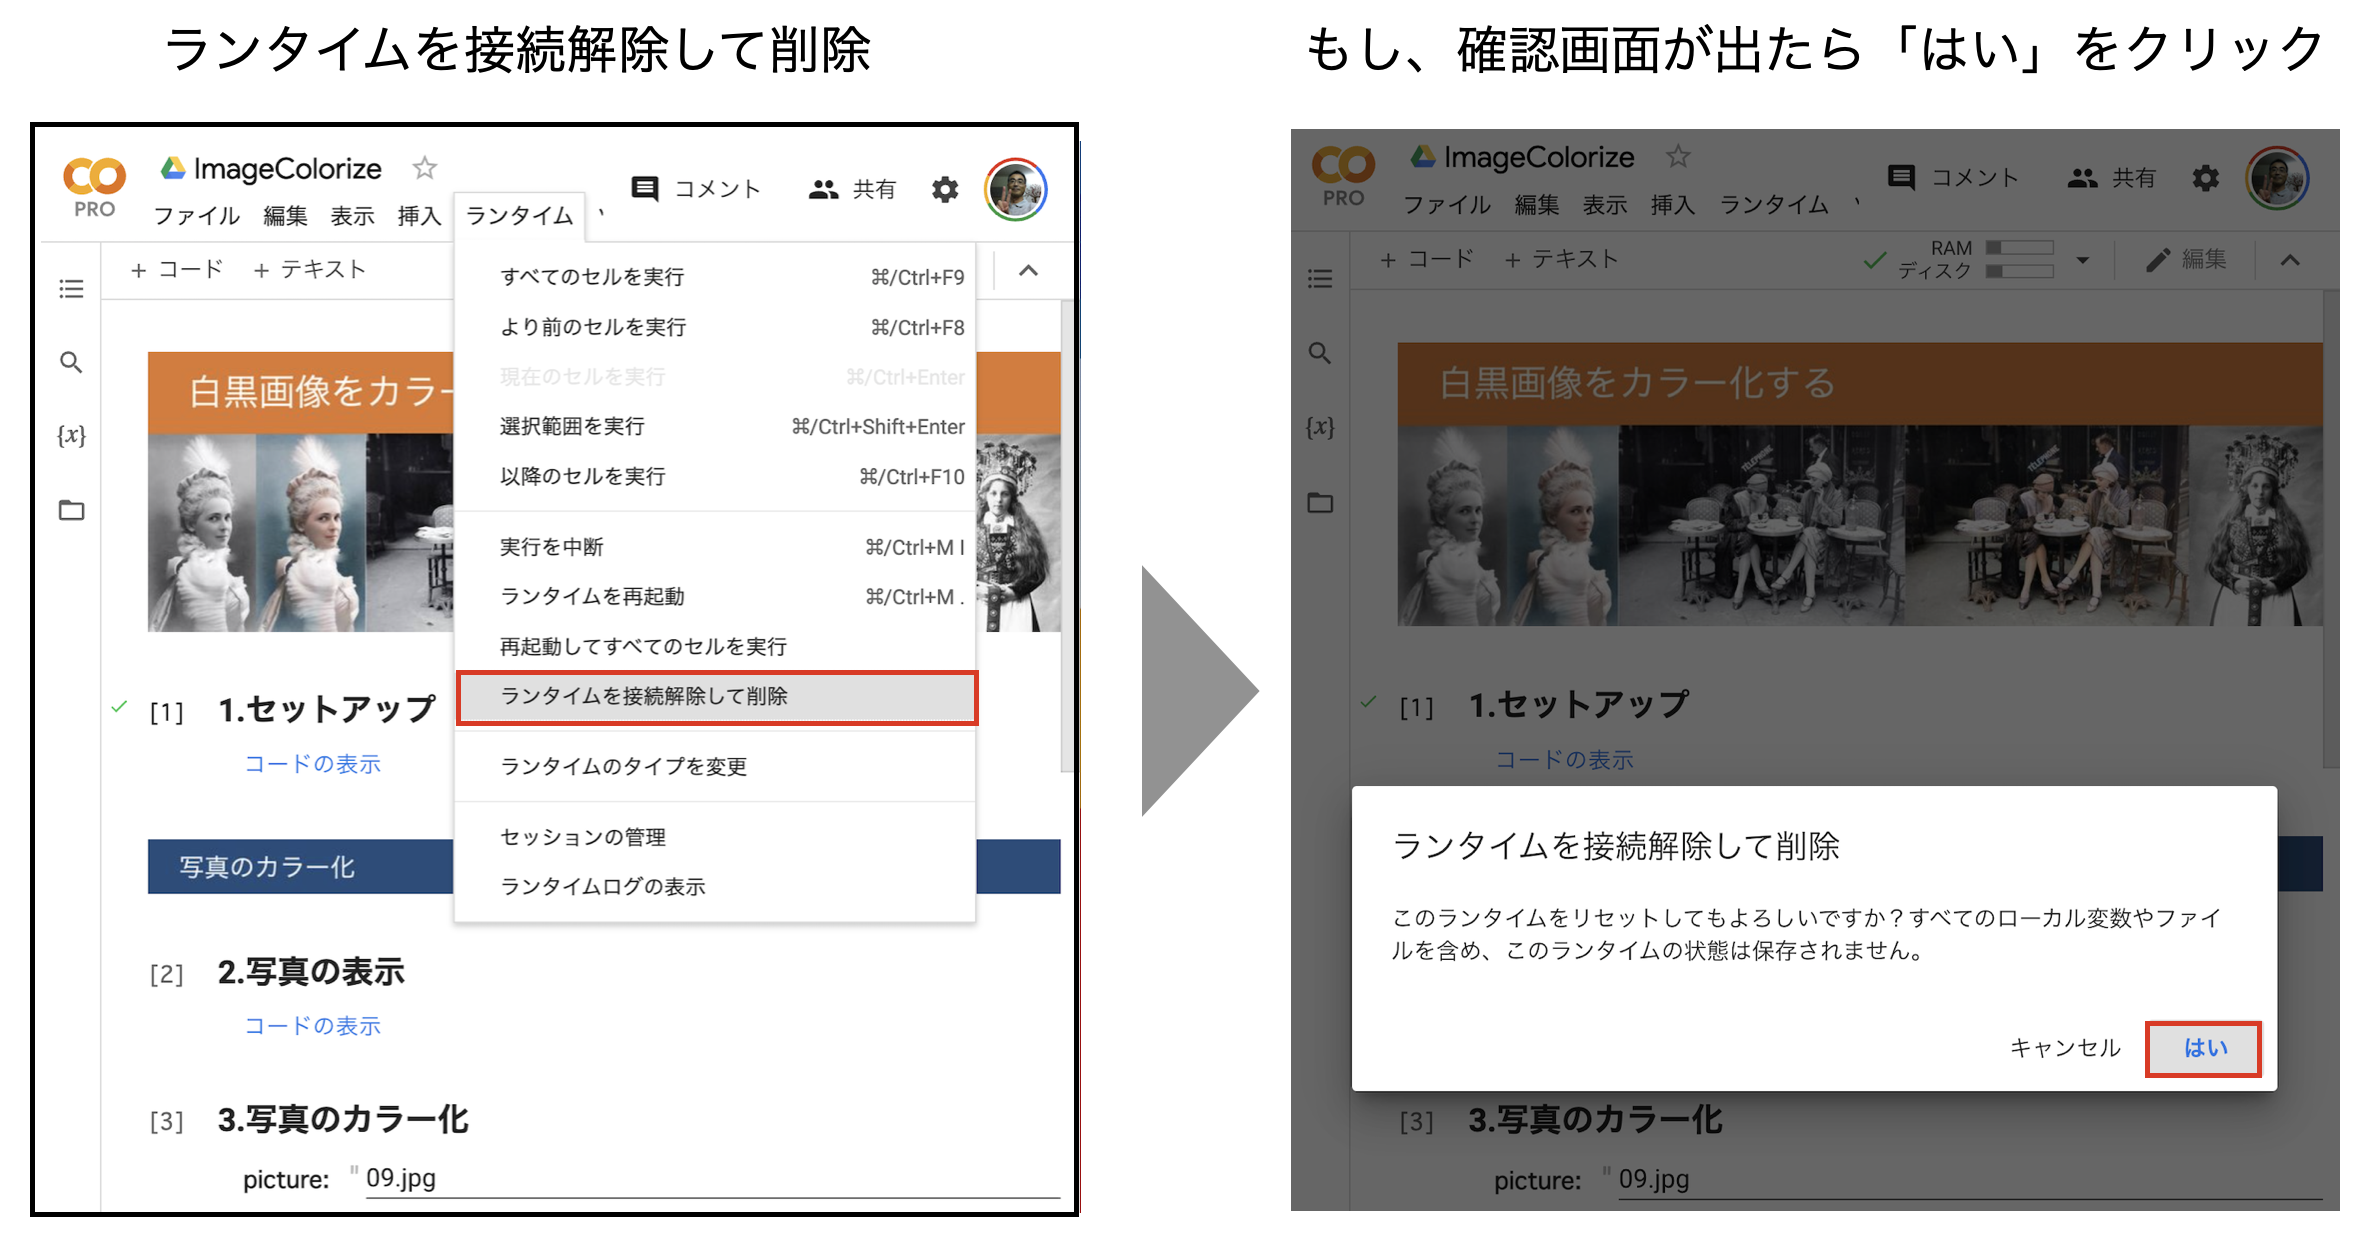